# Part 1. Data Processing
The following procedures demonstrate how the data for this project is collected, cleaned, and processed.

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

use_cuda=True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
uncleaned_data_path = "/content/gdrive/MyDrive/APS360 group project/uncleaned_data"

#Resize image, ensure all the same size for all images
transform = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ])

age_detect_dataset = torchvision.datasets.ImageFolder(uncleaned_data_path,
                                                     transform = transform)

age_detect_dataloader = torch.utils.data.DataLoader(age_detect_dataset,
                                                    batch_size=1,
                                                    shuffle=True)

folder = "/content/gdrive/MyDrive/APS360 group project/age_detect_proj/"

In [ ]:
classes = ['008','009','010','011',
           '012','013','014','015',
           '016','017','018','019',
           '020','021','022','023',
           '024','025','026','027',
           '028','029','030','031',
           '032','033','034','035',
           '036','037','038','039',
           '040','041','042','043',
           '044','045','046','047',
           '048','049','050','051',
           '052','053','054','055',
           '056','057','058','059',
           '060']

def save_equal_data(dataset, category):
  path = folder + category + '/'
  n = 0
  for image, label in age_detect_dataloader:
    if n >= 54:
      break
    if(int(classes[label]) == int(category)):
      torch.save(image.squeeze(0),
                    path + str(classes[label]) + '_' + str(n) + '.tensor')
      n += 1

In [ ]:
for age in classes:
  save_equal_data(age_detect_dataloader, str(age))

### Part (b) Splitting data to training validation and testing

In [ ]:
age_detect_dataset_path = "/content/gdrive/MyDrive/APS360 group project/age_detect_proj"
age_dataset = torchvision.datasets.DatasetFolder(age_detect_dataset_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
train_size = int(0.75 * len(age_dataset))
val_size = int(0.125 * len(age_dataset))
test_size = len(age_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    age_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                           num_workers=1, shuffle=True)

In [ ]:
print('There are',len(train_loader),
      'training images, which is {:.2f} % of the entire dataset.'.format(len(train_loader)/len(age_detect_dataset) * 100))
print('There are',len(val_loader),
      'validation images, which is {:.2f} % of the entire dataset.'.format(len(val_loader)/len(age_detect_dataset) * 100))
print('There are',len(test_loader),
      'test images, which is {:.2f} % of the entire dataset.'.format(len(test_loader)/len(age_detect_dataset) * 100))

There are 2117 training images, which is 35.75 % of the entire dataset.
There are 352 validation images, which is 5.94 % of the entire dataset.
There are 354 test images, which is 5.98 % of the entire dataset.


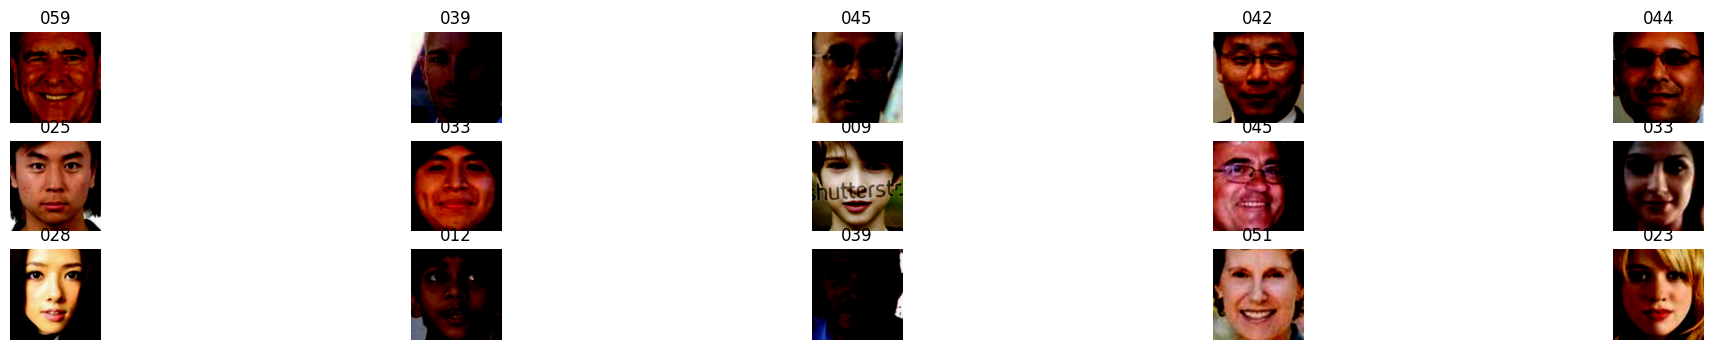

In [ ]:
#visualizing sample data
k = 0

classes = ['008','009','010','011',
           '012','013','014','015',
           '016','017','018','019',
           '020','021','022','023',
           '024','025','026','027',
           '028','029','030','031',
           '032','033','034','035',
           '036','037','038','039',
           '040','041','042','043',
           '044','045','046','047',
           '048','049','050','051',
           '052','053','054','055',
           '056','057','058','059',
           '060']

fig = plt.figure(figsize=(25, 4))

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    label = labels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img

    # Display the image
    ax = fig.add_subplot(3, 5, k+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(classes[label])  # Use label index to get the corresponding class

    k += 1
    if k >= 15:
        break

# Part 2. Baseline Model

In [ ]:
len(classes)

53

In [ ]:
#Convolutional Neural Network Architecture
#My CNN pass the image (3*200*200) to the first conv1 (input:3 output:5 kernel:5)
#Then it goes to the relu function and maxpooling layer(2,2)
#after that it goes to the second conv2 layer(5,10,5)
#and repeat the relu function and the maxpoolung layer, the size becomes(10*53*53)
#There are 7 layers in total, 2 conv layer, 2 maxpooling layer, 2 fully connected layer and 1 output layer
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10*47*47, 100)
        self.fc2 = nn.Linear(100, 53)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,10*47*47)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
def train(model, train_loader, val_loader, batch_size=64, l_r=0.005, num_epochs=5):
    criterion = nn.CrossEntropyLoss(ignore_index = -1)
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, l_r, epoch)
        torch.save(model.state_dict(), model_path)
        n+=1

        print(("Epoch: {} | Training Accuracy: {} | Validation Accuracy: {}").format(epoch+1, train_acc[epoch], val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_accuracy(model,train_loader,val_loader,train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


### Part (c) Training baseline model

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.022201228153046763 | Validation Accuracy: 0.014204545454545454
Epoch: 2 | Training Accuracy: 0.025035427491733587 | Validation Accuracy: 0.011363636363636364
Epoch: 3 | Training Accuracy: 0.05290505432215399 | Validation Accuracy: 0.014204545454545454
Epoch: 4 | Training Accuracy: 0.08880491261218705 | Validation Accuracy: 0.019886363636363636
Epoch: 5 | Training Accuracy: 0.18705715635333017 | Validation Accuracy: 0.048295454545454544
Epoch: 6 | Training Accuracy: 0.20453471894189892 | Validation Accuracy: 0.017045454545454544
Epoch: 7 | Training Accuracy: 0.018422295701464336 | Validation Accuracy: 0.019886363636363636
Epoch: 8 | Training Accuracy: 0.023618327822390175 | Validation Accuracy: 0.008522727272727272
Epoch: 9 | Training Accuracy: 0.02172886159659896 | Validation Accuracy: 0.008522727272727272
Epoch: 10 | Training Accuracy: 0.019367028814359942 | Validation Accuracy: 0.019886363636363636
Epoch: 11 | Tr

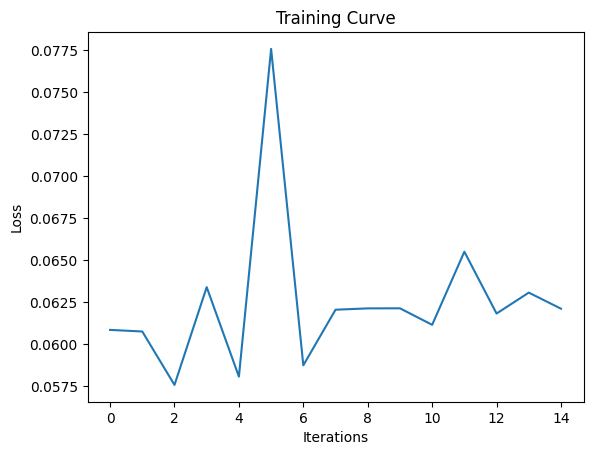

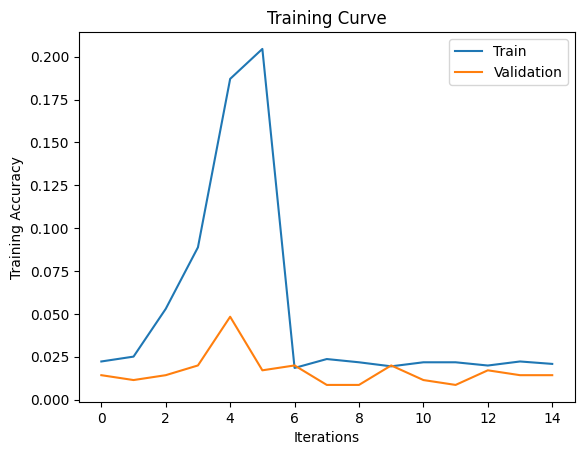

Final Training Accuracy: 0.020784128483703354
Final Validation Accuracy: 0.014204545454545454


In [ ]:
model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_loader, val_loader, num_epochs=15)

# Part 3. Alex Net

### Part (a). AlexNet Implementation


In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 236MB/s]


In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

# location on Google Drive
alexnet_path = '/content/gdrive/MyDrive/APS360 group project/new_alexnet_feature'

# define pre-set data
batch_size = 1
num_workers = 1

def get_alexnet_feature(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
  n = 0
  folder = alexnet_path + '/'

  # save features to folder as tensors
  # the print are for checking how much images are completed in the transformation
  for img, label in loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      torch.save(features_tensor.squeeze(0),
                 folder + '/' + str(classes[label]) + '/' + str(classes[label]) + '_' + str(n) + '.tensor')
      n += 1

In [ ]:
get_alexnet_feature(age_dataset)

In [ ]:
alex_dataset = torchvision.datasets.DatasetFolder(alexnet_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
train_size = int(0.75 * len(age_dataset))
val_size = int(0.125 * len(age_dataset))
test_size = len(age_dataset) - train_size - val_size

alex_train_set, alex_val_set, alex_test_set = torch.utils.data.random_split(
    alex_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
alex_train_loader = torch.utils.data.DataLoader(alex_train_set, batch_size=1,
                                           num_workers=1, shuffle=True)
alex_val_loader = torch.utils.data.DataLoader(alex_val_set, batch_size=1,
                                           num_workers=1, shuffle=True)
alex_test_loader = torch.utils.data.DataLoader(alex_test_set, batch_size=1,
                                           num_workers=1, shuffle=True)

In [ ]:
print('There are',len(alex_train_loader),
      'training images, which is {:.2f} % of the entire dataset.'.format(len(train_loader)/len(age_dataset) * 100))
print('There are',len(alex_val_loader),
      'validation images, which is {:.2f} % of the entire dataset.'.format(len(val_loader)/len(age_dataset) * 100))
print('There are',len(alex_test_loader),
      'test images, which is {:.2f} % of the entire dataset.'.format(len(test_loader)/len(age_dataset) * 100))

There are 2117 training images, which is 74.99 % of the entire dataset.
There are 352 validation images, which is 12.47 % of the entire dataset.
There are 354 test images, which is 12.54 % of the entire dataset.


In [ ]:
for img, label in alex_train_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(alex_train_loader)

Data type of img: <class 'torch.Tensor'>
Data size of img: torch.Size([1, 256, 5, 5])
Data type of label: <class 'torch.Tensor'>
Data type of img tensor elements: torch.float32


2117

### Part (b). Neural Network

In [ ]:
class CNN_features(nn.Module):

      def __init__(self):
          self.name = "CNN_features"
          super(CNN_features, self).__init__()
          self.fc1 = nn.Linear(256*5*5, 1024)
          self.fc2 = nn.Linear(1024, 512)
          self.fc3 = nn.Linear(512,128)
          self.fc4 = nn.Linear(128,53)
      def forward(self, x):
          x = x.view(-1,256*5*5)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          x = self.fc4(x)
          return x

### Part (c). Training

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.021256495040151157 | Validation Accuracy: 0.011363636363636364
Epoch: 2 | Training Accuracy: 0.01889466225791214 | Validation Accuracy: 0.014204545454545454
Epoch: 3 | Training Accuracy: 0.02172886159659896 | Validation Accuracy: 0.011363636363636364
Epoch: 4 | Training Accuracy: 0.03401039206424185 | Validation Accuracy: 0.022727272727272728
Epoch: 5 | Training Accuracy: 0.01983939537080775 | Validation Accuracy: 0.014204545454545454
Epoch: 6 | Training Accuracy: 0.028814359943316013 | Validation Accuracy: 0.014204545454545454
Epoch: 7 | Training Accuracy: 0.02031176192725555 | Validation Accuracy: 0.022727272727272728
Epoch: 8 | Training Accuracy: 0.021256495040151157 | Validation Accuracy: 0.017045454545454544
Epoch: 9 | Training Accuracy: 0.022201228153046763 | Validation Accuracy: 0.014204545454545454
Epoch: 10 | Training Accuracy: 0.020784128483703354 | Validation Accuracy: 0.017045454545454544
Epoch: 11 | Tr

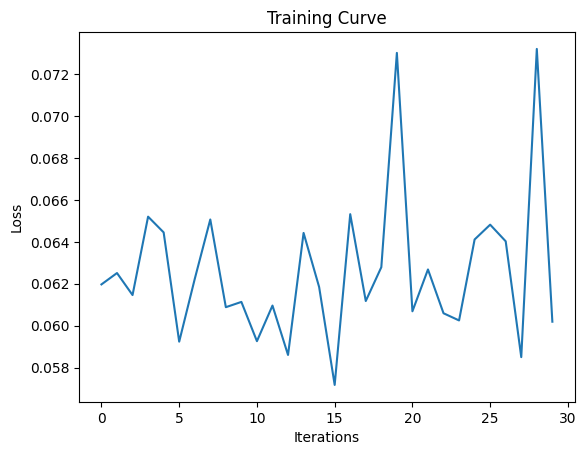

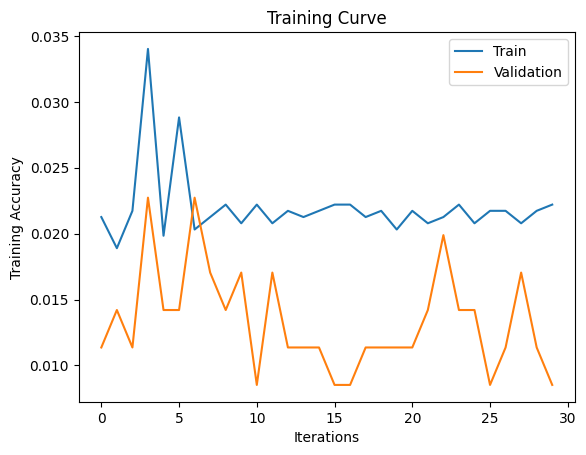

Final Training Accuracy: 0.022201228153046763
Final Validation Accuracy: 0.008522727272727272


In [ ]:
model_1 = CNN_features()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train(model_1, alex_train_loader, alex_val_loader, l_r=0.005,num_epochs=30)